## Purpose of this notebook:
Build a very simple model to set baseline of performance. This model will be composed of a flatten layer for image input, a single dense layer with 16 nodes, and an output layer with a sigmoid activation function for classification. 

Workflow:
1. Import Data
2. Build Model
3. Train
4. Evaluate

In [2]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# Evaluation
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from keras import metrics

# Modelling
from keras.models import Sequential
from keras.layers import Flatten, Dense

# Preprocessing
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Custom Functions
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
import src.functions as fn

### Data import
The cell below instantiates 3 keras ImageDataGenerator objects and directory iterators for each one. 
These can be passed to a keras model's fit or evaluate methods and will act as though they were arrays of data without having to import the entire image dataset.
- All pixel values are scaled by 1/225.
- All images are rescaled to 100, 100, and reduced to greyscale (1 channel)
- Training data was augmented with a zoom range of .2 and horizontal flipping

In [3]:
train_gen, val_gen, test_gen = fn.load_data_generators()

Found 2568 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Model Parameters:
- Layers:
 - Flatten layer: Input
 - Dense layer: 16 nodes, ReLU activation
 - Output layer: Sigmoid activation
- Optimizer: Adam
- Loss: Binary Crossentropy

In [4]:
model = Sequential()
model.add(Flatten(input_shape=(100,100,1)))
model.add(Dense(units=16, 
                activation='relu'))
model.add(Dense(units=1, 
                activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall')
    ])

### Fit model
- Trained for 10 epochs
- Number of steps is set equal to the length of the data generator which means it will run through the entire data folder at each epoch.

In [6]:
history = model.fit(train_gen, 
                    epochs=10, 
                    validation_data=(val_gen), 
                    steps_per_epoch=len(train_gen), 
                    validation_steps=len(val_gen))

Epoch 1/10
81/81 [==============================] - 88s 1s/step - loss: 0.7642 - accuracy: 0.5393 - precision: 0.5562 - recall: 0.8712 - val_loss: 0.6906 - val_accuracy: 0.6218 - val_precision: 0.6218 - val_recall: 1.0000
Epoch 2/10
81/81 [==============================] - 46s 570ms/step - loss: 0.6912 - accuracy: 0.5592 - precision: 0.5592 - recall: 1.0000 - val_loss: 0.6868 - val_accuracy: 0.6218 - val_precision: 0.6218 - val_recall: 1.0000
Epoch 3/10
81/81 [==============================] - 47s 578ms/step - loss: 0.6897 - accuracy: 0.5592 - precision: 0.5592 - recall: 1.0000 - val_loss: 0.6840 - val_accuracy: 0.6218 - val_precision: 0.6218 - val_recall: 1.0000
Epoch 4/10
81/81 [==============================] - 48s 598ms/step - loss: 0.6887 - accuracy: 0.5592 - precision: 0.5592 - recall: 1.0000 - val_loss: 0.6816 - val_accuracy: 0.6218 - val_precision: 0.6218 - val_recall: 1.0000
Epoch 5/10
81/81 [==============================] - 47s 575ms/step - loss: 0.6879 - accuracy: 0.5592 - 

## Evaluation

In [7]:
acc = model.evaluate(test_gen, steps=len(test_gen), verbose=1)
list(zip(model.metrics_names, acc))

20/20 [==============================] - 11s 570ms/step - loss: 0.6735 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000


[('loss', 0.673467755317688),
 ('accuracy', 0.625),
 ('precision', 0.625),
 ('recall', 1.0)]

### Business interpetation of Metrics:
The recall (sensitivity) score of 100% means that no ill patient went undetected in our test set.
The precision score of 62.5% means that almost 40% of patients without pneumonia are being flagged.
Reducing the precision score will be beneficial for optimizing the efficiency of radiologists, but it should not be optimized at great cost to the recall score as this is still the priority.

In terms of overall accuracy, this model's score of 62.5% is slightly better than random chance.

#### Create test set array
This makes it easier to create a confusion matrix.

In [10]:
X, y = fn.generator_to_array(test_gen)

In [11]:
y_hat = model.predict_classes(X)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


/home/max/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624

Accurancy:  0.625


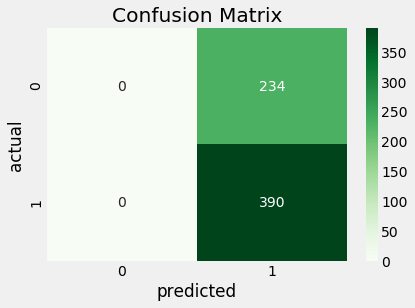

In [12]:
fn.evaluation(y, y_hat)

### Essentially a Dummy model

This confusion matrix only guessed pneumonia on the test set, which explains the low accuracy and precision score.

In [13]:
accuracy = history.history['accuracy']
loss = history.history['loss']

val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

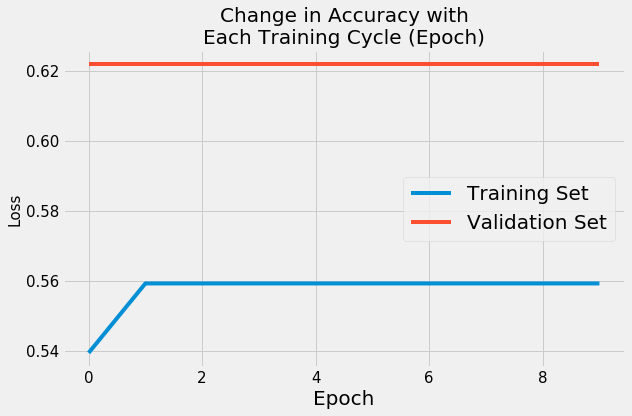

In [19]:
fig, ax = plt.subplots(1,1, figsize=(9,6))

sns.lineplot(range(len(accuracy)), accuracy, ax=ax, label='Training Set')
# sns.lineplot(range(len(loss)), loss, ax=ax[1])

sns.lineplot(range(len(val_accuracy)), val_accuracy, ax=ax, label='Validation Set')
# sns.lineplot(range(len(val_loss)), val_loss, ax=ax[1])

ax.set_title("Change in Accuracy with\nEach Training Cycle (Epoch)", fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=20)
ax.tick_params(labelsize='15')
ax.legend(loc='center right', fontsize=20)
plt.tight_layout()

# plt.savefig('accuracy_with_val.png', transparency=True) # uncomment to save image

### This graph indicates that the model stopped fitting in any meaningful way at the first epoch